In [92]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import re
import os
import glob

# Add parent directory to access scib module
import sys
sys.path.append('../')
from scib import Plotter

# Set font size for plots
plt.rcParams["font.size"] = 18

In [93]:
# Define categories for different types of logs and their corresponding patterns
log_categories = {
    'adv': {
        'columns': ['time', 'addr'],
        'dtypes': [int, str],
        'pattern': r'00> (\d{10}),a,([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'connected': {
        'columns': ['time', 'conn_handle', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),c,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'disconnected': {
        'columns': ['time', 'cmu_index', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),d,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'vs': {
        'columns': ['time', 'conn_handle', 'cc'],
        'dtypes': [int, int, int],
        'pattern': r'00> (\d{10}),v,(\d+),(\d+$)'
    },
    'qos': {
        'columns': ['time', 'conn_handle', 'channel_index', 'event_counter', 'crc_ok_count', 'crc_error_count', 'nak_count', 'rx_timeout', 'rssi'],
        'dtypes': [int, int, int, int, int, int, int, int, int],
        'pattern': r'00> (\d{10}),q,(\d+),(\d+),(\d{6}),(\d+),(\d+),(\d+),(\d+),(-\d+$)'
    }
}

In [94]:
# Set directory name for log files
log_dir = 'log'

# Set file names for different groups of logs
log_files = {
    'g1': '20230418-1335-bmu.log'
}

# Create empty dictionary to store dataframes for each group
dfs = {}
for group in log_files.keys():
    dfs[group] = {}

In [95]:
# Set filename for saving and loading dataframes
dfs_filename = os.path.join(log_dir, 'dfs.pickle')

# Check if dataframes have already been created and saved
if os.path.isfile(dfs_filename):
    with open(dfs_filename, 'rb') as f:
        dfs = pickle.load(f)
        print('dfs has been loaded.')
else:
    for group, filename in log_files.items():
        print(group)
        with open(os.path.join(log_dir, filename)) as f:
            lines = f.readlines()
            for df_name, info in log_categories.items():
                repatter = re.compile(info['pattern'])
                match_lines = [repatter.match(l).groups() for l in lines if repatter.match(l)]
                dfs[group][df_name] = pd.DataFrame(match_lines, columns=info['columns'], dtype=str)
                for column, dtype in zip(info['columns'], info['dtypes']):
                    dfs[group][df_name][column] = dfs[group][df_name][column].astype(dtype)
                dfs[group][df_name]['timedelta'] = dfs[group][df_name]['time'].apply(lambda x: datetime.timedelta(milliseconds=x))
                dfs[group][df_name].set_index('timedelta')
    with open(dfs_filename, 'wb') as f:
        pickle.dump(dfs, f)
        print('dfs has been dumped.')

dfs has been loaded.


In [96]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:33:35.716000


In [97]:
n_cmu = 0
for group in dfs.keys():
    n_cmu = max(n_cmu, len(dfs[group]['connected']['conn_handle'].unique()))
n_cmu

1

In [98]:
dfs['g1']['qos']

time  conn_handle  channel_index  event_counter  crc_ok_count   
0     1311436            0              5          21848             1  \
1     1311496            0              0          21849             1   
2     1311556            0              8          21850             1   
3     1311616            0             18          21851             0   
4     1311676            0             23          21852             0   
...       ...          ...            ...            ...           ...   
9994  2015656            0             21          33585             0   
9995  2015716            0              0          33586             1   
9996  2015776            0             32          33587             0   
9997  2015836            0             18          33588             0   
9998  2015896            0             16          33589             0   

      crc_error_count  nak_count  rx_timeout  rssi              timedelta  
0                   0          0           0   -45 0 days 00:21:51.436000  
1                   0          0           0   -43 0 days 00:21:51.496000  
2                   0          0           0   -48 0 days 00:21:51.556000  
3                   0          0           1   -48 0 days 00:21:51.616000  
4                   0          0           1   -48 0 days 00:21:51.676000  
...               ...        ...         ...   ...                    ...  
9994                0          0           1   -47 0 days 00:33:35.656000  
9995                0          0           0   -43 0 days 00:33:35.716000  
9996                0          0           1   -43 0 days 00:33:35.776000  
9997                0          0           1   -43 0 days 00:33:35.836000  
9998                0          0           1   -43 0 days 00:33:35.896000  

[9999 rows x 10 columns]

In [99]:
# create dictionary called group_handle2addr which will store the Bluetooth addresses of the devices that are connected to each group
group_handle2addr = {}
for group in dfs.keys():
    group_handle2addr[group] = {}
    for conn_handle in range(n_cmu):
        group_handle2addr[group][conn_handle] = dfs[group]['connected'].query('conn_handle==@conn_handle').iloc[-1]['addr']
group_handle2addr

{'g1': {0: 'EF:F5:AE:F2:26:55'}}

In [100]:
datetime.timedelta(minutes=30).total_seconds() * 1000

1800000.0

In [101]:
# Remove first 30 minutes and leave 8 hours data
# for group, df_group in dfs.items():
#     for category, df in df_group.items():
#         time_start = datetime.timedelta(minutes=30).total_seconds() * 1000
#         time_end = time_start + datetime.timedelta(hours=8).total_seconds() * 1000
#         dfs[group][category] = df.query('@time_start < time < @time_end').reset_index(drop=True)

In [102]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:33:35.716000


In [103]:
# Check the number of conn handle
for group in dfs.keys():
    print(group, len(dfs[group]['vs']['conn_handle'].unique()))

g1 1


In [104]:
for group in dfs.keys():  # Iterate over each group in the dfs dictionary
    for conn_handle in range(n_cmu):  # Iterate over each connection handle
        # Calculate delayed flag for the current connection handle in the current group
        # based on a time difference threshold of 150 milliseconds
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].query('conn_handle==@conn_handle')['time'].diff()>150
        
        # Convert the delayed flag from boolean to float data type
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'].astype(float)


In [105]:
# Check the number of disconnection
for group in dfs.keys():
    print(group, len(dfs[group]['disconnected']))

g1 0


## Analysis 



In [106]:
#returns the highest channel index number used for Quality of Service (QoS) measurements in the 'g1' group.
dfs['g1']['qos']['channel_index'].max()

36

In [107]:
dfs['g1']['qos'][['crc_ok_count', 'crc_error_count']].drop_duplicates()

crc_ok_count  crc_error_count
0                1                0
3                0                0
14               2                0
48               0                2
49               0                1
50               3                0
82               2                1
379              1                1
1025             4                0
1662             6                0
3699             5                0
6280             1                3
7087             3                1

In [108]:
dfs['g1']['qos']

time  conn_handle  channel_index  event_counter  crc_ok_count   
0     1311436            0              5          21848             1  \
1     1311496            0              0          21849             1   
2     1311556            0              8          21850             1   
3     1311616            0             18          21851             0   
4     1311676            0             23          21852             0   
...       ...          ...            ...            ...           ...   
9994  2015656            0             21          33585             0   
9995  2015716            0              0          33586             1   
9996  2015776            0             32          33587             0   
9997  2015836            0             18          33588             0   
9998  2015896            0             16          33589             0   

      crc_error_count  nak_count  rx_timeout  rssi              timedelta  
0                   0          0           0   -45 0 days 00:21:51.436000  
1                   0          0           0   -43 0 days 00:21:51.496000  
2                   0          0           0   -48 0 days 00:21:51.556000  
3                   0          0           1   -48 0 days 00:21:51.616000  
4                   0          0           1   -48 0 days 00:21:51.676000  
...               ...        ...         ...   ...                    ...  
9994                0          0           1   -47 0 days 00:33:35.656000  
9995                0          0           0   -43 0 days 00:33:35.716000  
9996                0          0           1   -43 0 days 00:33:35.776000  
9997                0          0           1   -43 0 days 00:33:35.836000  
9998                0          0           1   -43 0 days 00:33:35.896000  

[9999 rows x 10 columns]

In [109]:
dfs['g1']['qos']['crc_error_count'].sum()

133

In [110]:
dfs['g1']['qos'].query('channel_index==0')

time  conn_handle  channel_index  event_counter  crc_ok_count   
1     1311496            0              0          21849             1  \
30    1417816            0              0          23621             1   
35    1418116            0              0          23626             1   
107   1422436            0              0          23698             1   
145   1424716            0              0          23736             1   
...       ...          ...            ...            ...           ...   
9837  2006236            0              0          33428             1   
9882  2008936            0              0          33473             1   
9929  2011756            0              0          33520             1   
9954  2013256            0              0          33545             1   
9995  2015716            0              0          33586             1   

      crc_error_count  nak_count  rx_timeout  rssi              timedelta  
1                   0          0           0   -43 0 days 00:21:51.496000  
30                  0          0           0   -45 0 days 00:23:37.816000  
35                  0          0           0   -44 0 days 00:23:38.116000  
107                 0          0           0   -38 0 days 00:23:42.436000  
145                 0          0           0   -44 0 days 00:23:44.716000  
...               ...        ...         ...   ...                    ...  
9837                0          0           0   -40 0 days 00:33:26.236000  
9882                0          0           0   -44 0 days 00:33:28.936000  
9929                0          0           0   -43 0 days 00:33:31.756000  
9954                0          0           0   -43 0 days 00:33:33.256000  
9995                0          0           0   -43 0 days 00:33:35.716000  

[263 rows x 10 columns]

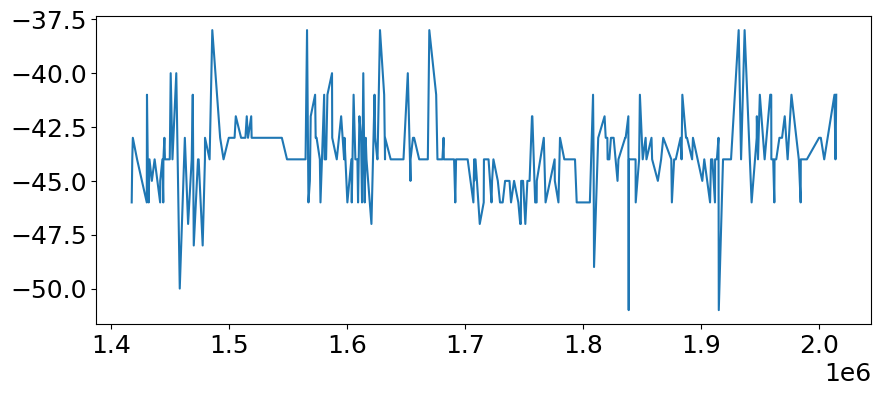

In [111]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
df=dfs['g1']['qos'].query('channel_index==3')
x=df['time']
y=df['rssi']
ax.plot(x, y)

In [112]:
for group in dfs.keys():
    dfs[group]['qos']['result'] = pd.Series(dtype=str)
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']==0) & (dfs[group]['qos']['crc_error_count']==0), 'result'] = 'not arrived'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']>0), 'result'] = 'ok'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_error_count']>0), 'result'] = 'error'

g1	0	max delay:104760.0(ms)	max delay(qos):104639.0(ms)	

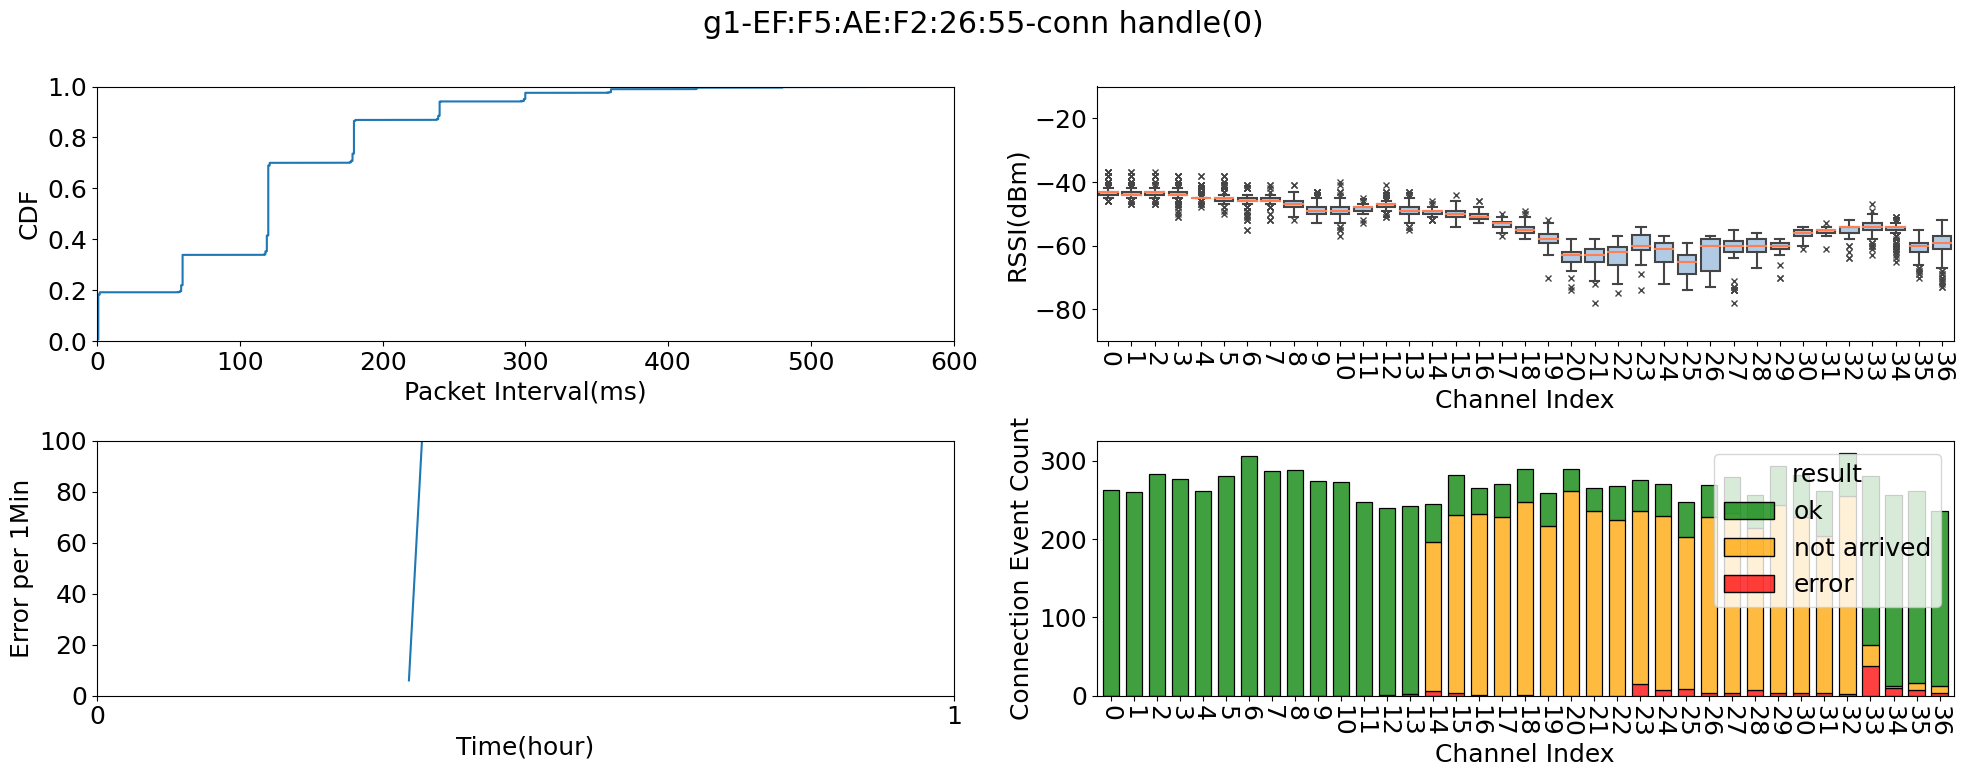

In [113]:
# delay check
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        print(group, end='\t')
        print(conn_handle, end='\t')
        df_diff = df_group['vs'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay:{df_diff.max()}(ms)', end='\t')
        # print(f'delay prob:{len(df_diff[df_diff>150])/len(df_diff):.5e}')
        df_diff_qos = df_group['qos'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay(qos):{df_diff_qos.max()}(ms)', end='\t')

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle(f'{group}-{addr}-conn handle({conn_handle})')
        ax1 = fig.add_subplot(2, 2, 1)
        Plotter.ecdf(df_group['vs'], conn_handle, ax1)

        ax2 = fig.add_subplot(2, 2, 2)
        Plotter.rssi_box(df_group['qos'].query('result=="ok"'), conn_handle, ax2) # filter the rows of the 'qos' DataFrame where the value in the 'result' column is equal to 'ok'. 

        ax3 = fig.add_subplot(2,2,3)
        Plotter.delay_transition_qos(df_group['qos'], conn_handle, ax3, ylim=(0, 100))
        # Plotter.delay_transition(df_group['vs'], conn_handle, ax3)

        ax4 = fig.add_subplot(2, 2, 4)
        Plotter.crc_hist(df_group['qos'], conn_handle, ax4)

        plt.tight_layout()
        plt.show()

        list(df_group['qos'][df_group['qos']['conn_handle'] == conn_handle]['channel_index'].unique())
        print()

g1	0	max delay:104760.0(ms)	max delay(qos):104639.0(ms)	

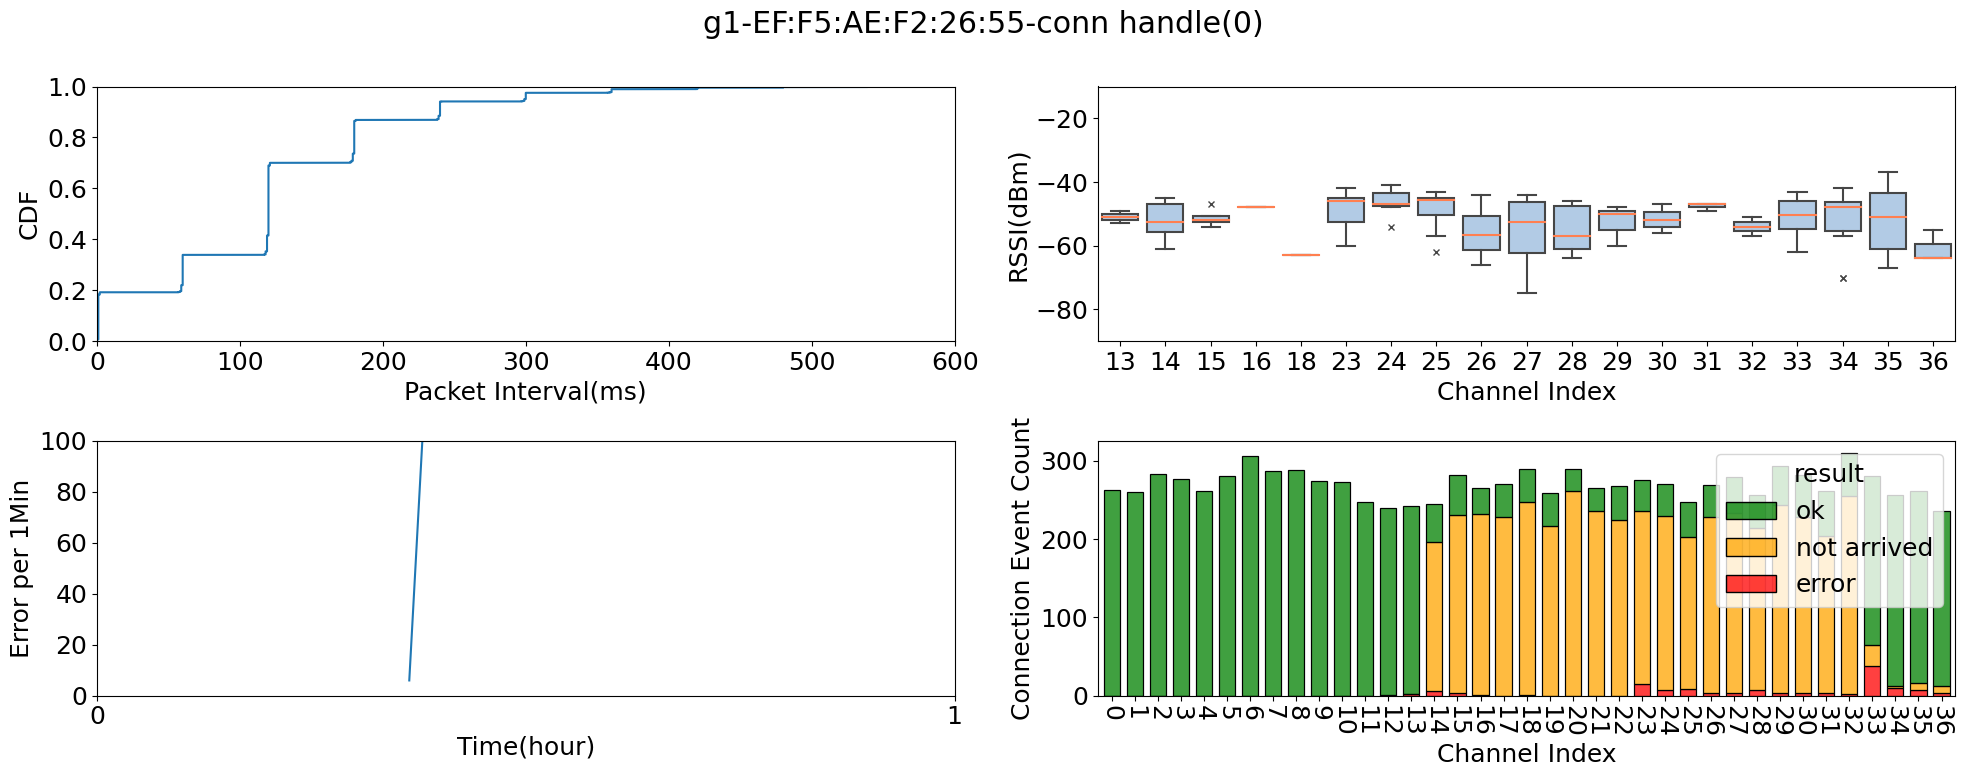

In [114]:
# delay check
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        print(group, end='\t')
        print(conn_handle, end='\t')
        df_diff = df_group['vs'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay:{df_diff.max()}(ms)', end='\t')
        # print(f'delay prob:{len(df_diff[df_diff>150])/len(df_diff):.5e}')
        df_diff_qos = df_group['qos'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay(qos):{df_diff_qos.max()}(ms)', end='\t')

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle(f'{group}-{addr}-conn handle({conn_handle})')
        ax1 = fig.add_subplot(2, 2, 1)
        Plotter.ecdf(df_group['vs'], conn_handle, ax1)

        ax2 = fig.add_subplot(2, 2, 2)
        Plotter.rssi_box(df_group['qos'].query('result=="error"'), conn_handle, ax2)  #filter the rows of the 'qos' DataFrame where the value in the 'result' column is equal to 'error'. 

        ax3 = fig.add_subplot(2,2,3)
        Plotter.delay_transition_qos(df_group['qos'], conn_handle, ax3, ylim=(0, 100))
        # Plotter.delay_transition(df_group['vs'], conn_handle, ax3)

        ax4 = fig.add_subplot(2, 2, 4)
        Plotter.crc_hist(df_group['qos'], conn_handle, ax4)

        plt.tight_layout()
        plt.show()

        list(df_group['qos'][df_group['qos']['conn_handle'] == conn_handle]['channel_index'].unique())
        print()

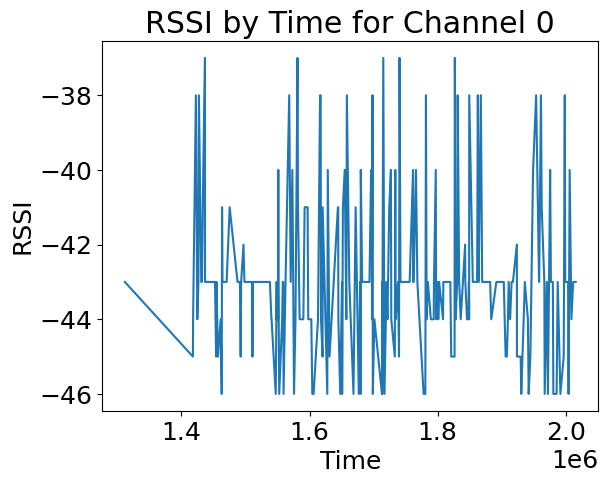

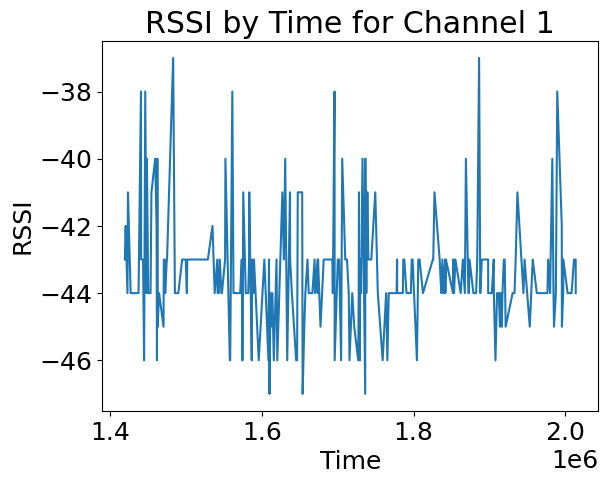

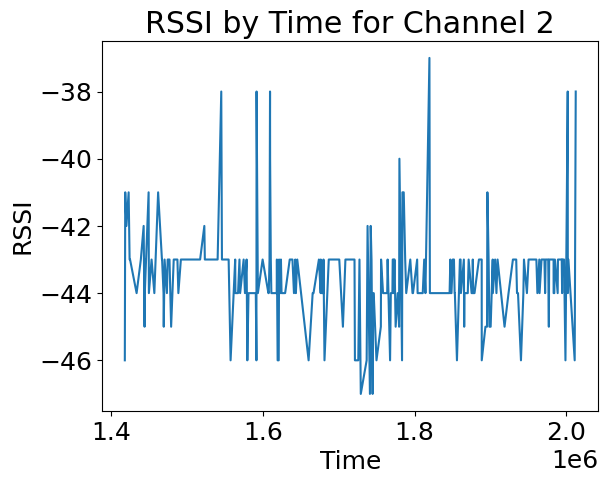

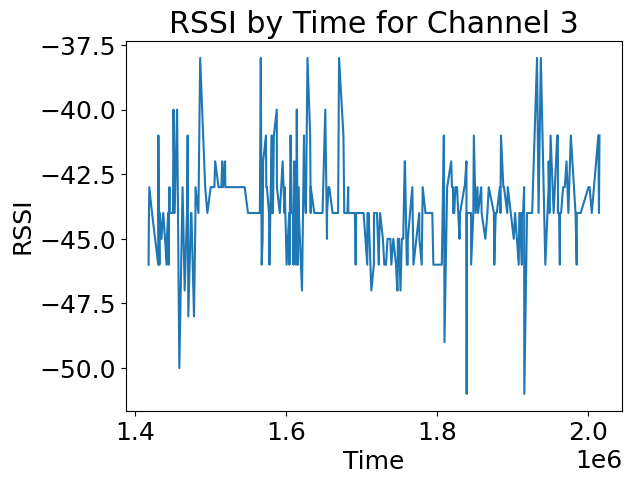

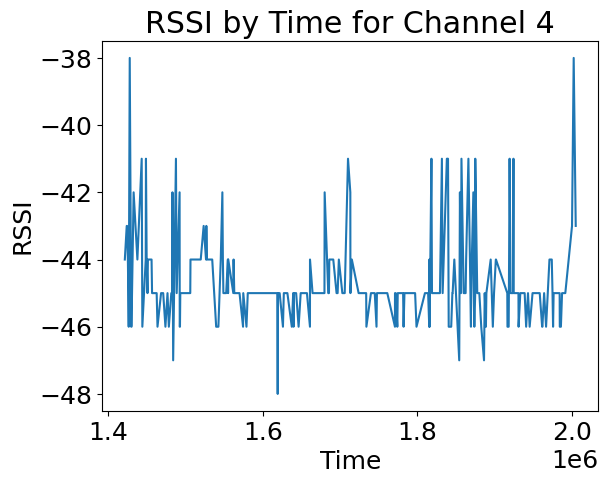

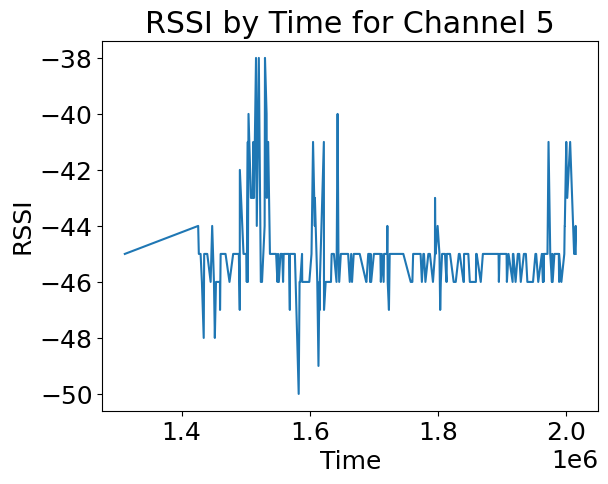

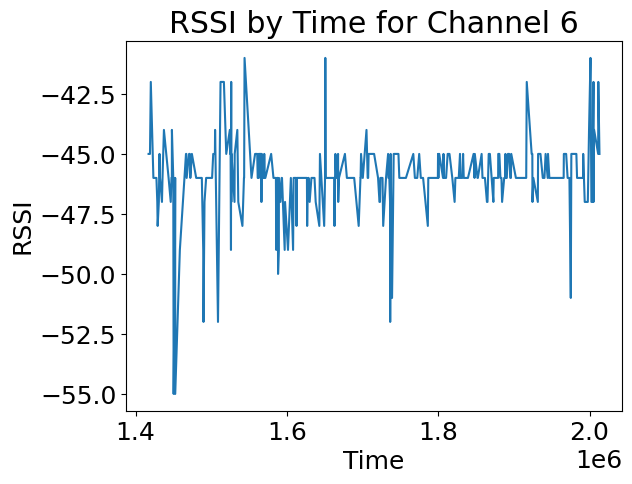

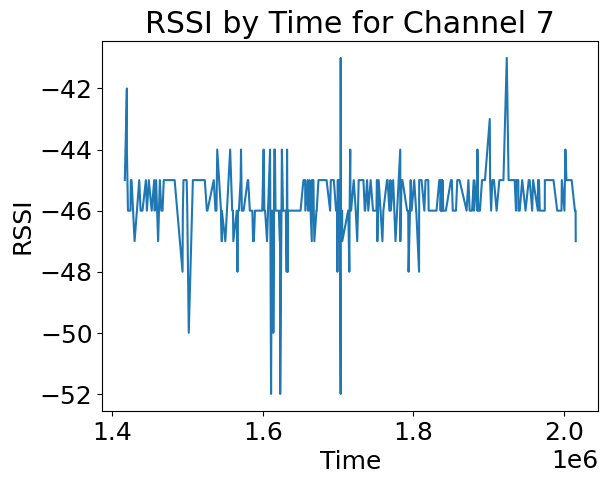

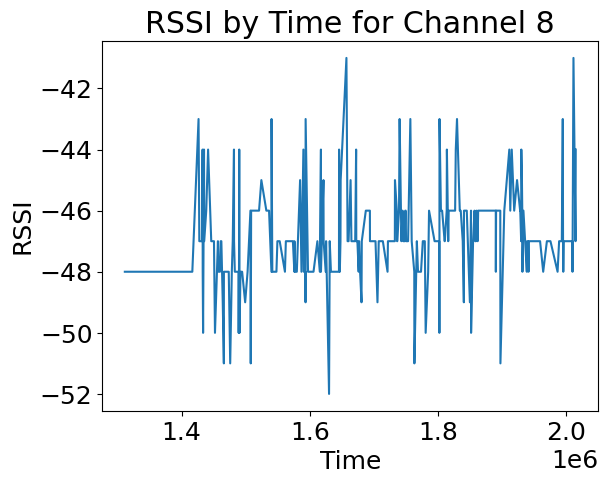

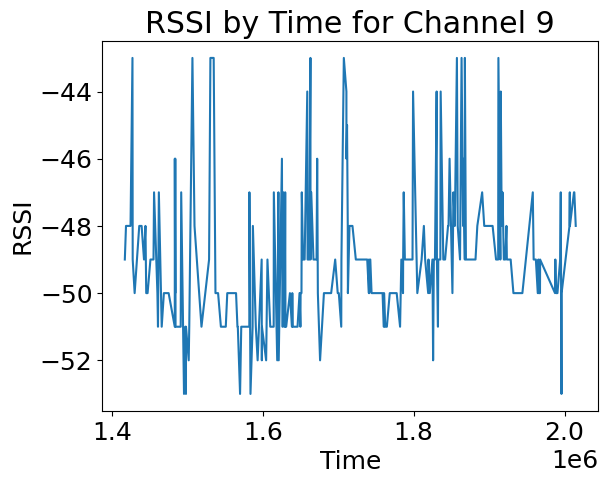

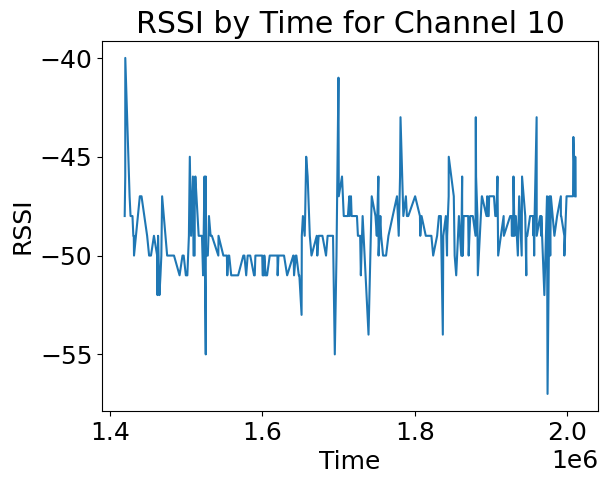

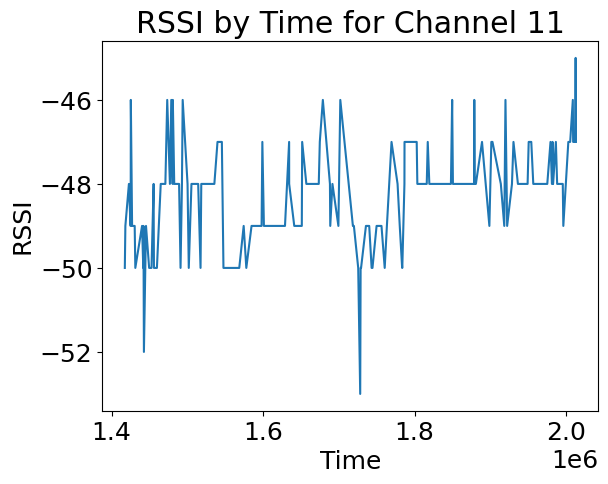

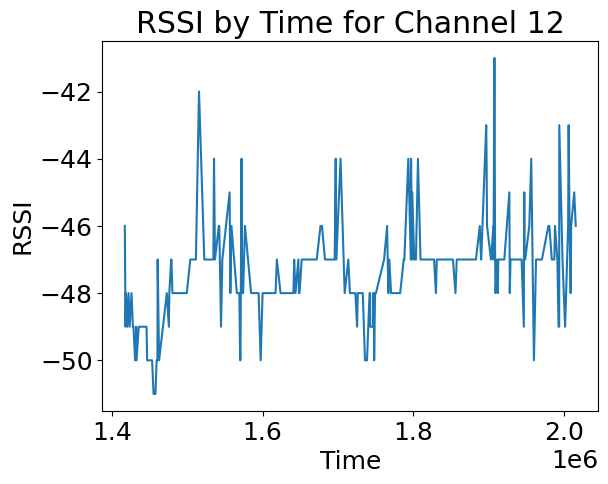

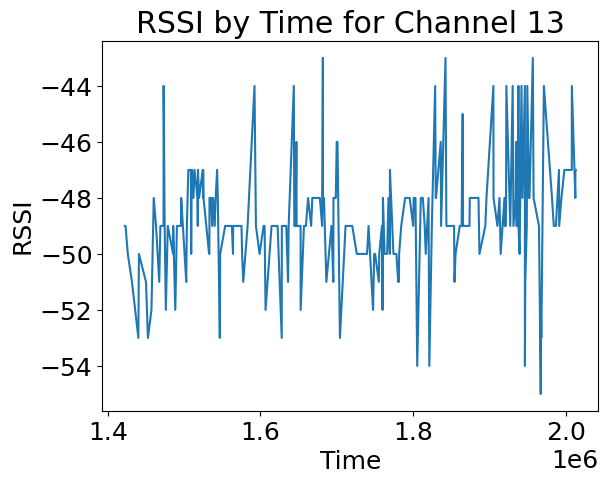

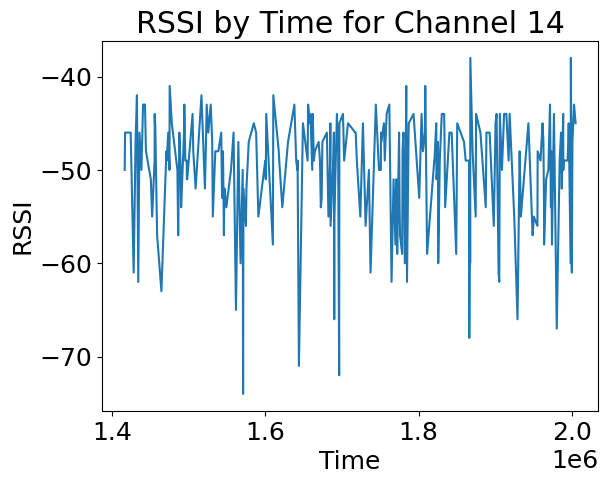

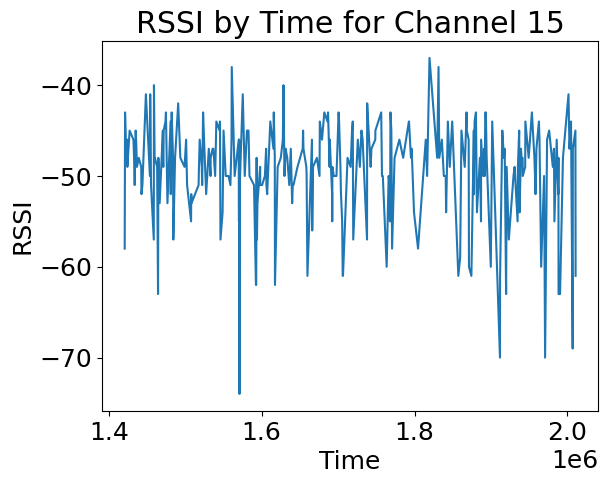

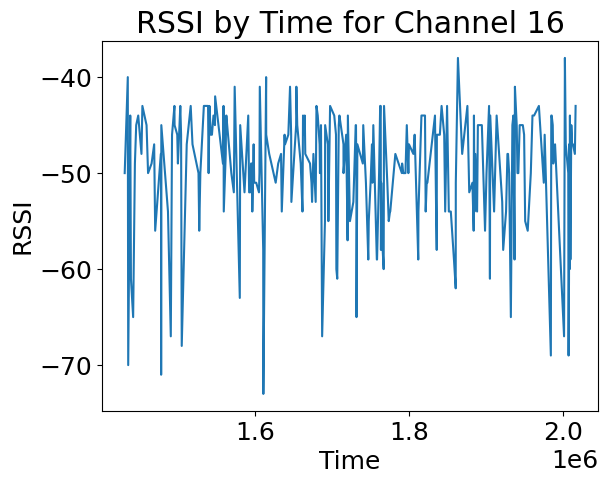

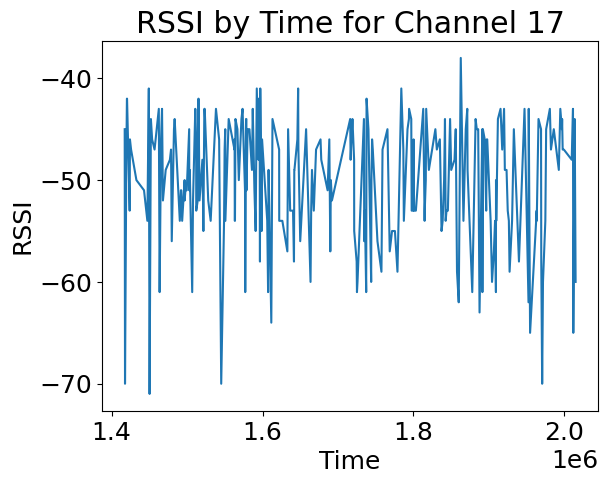

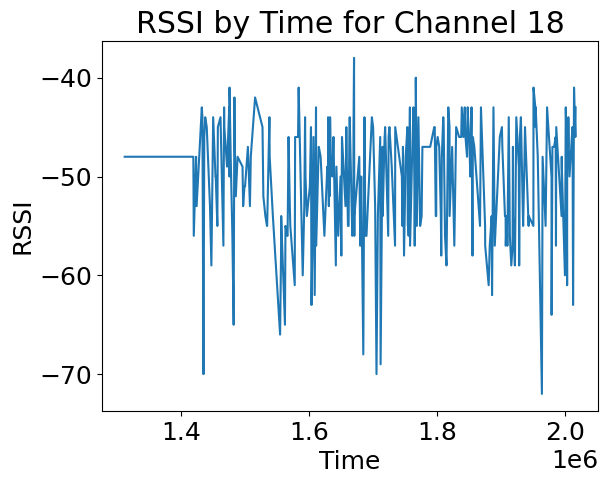

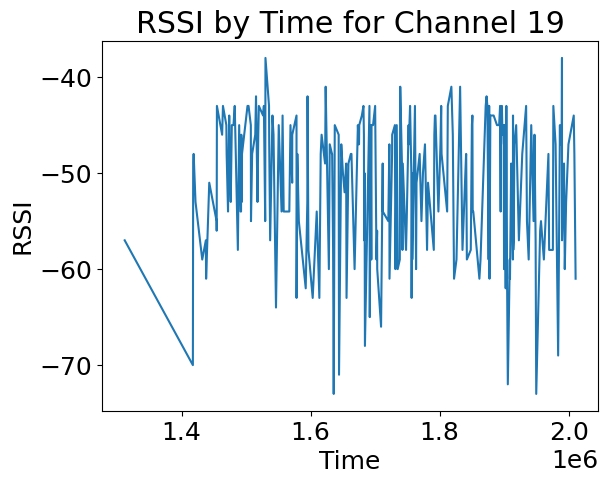

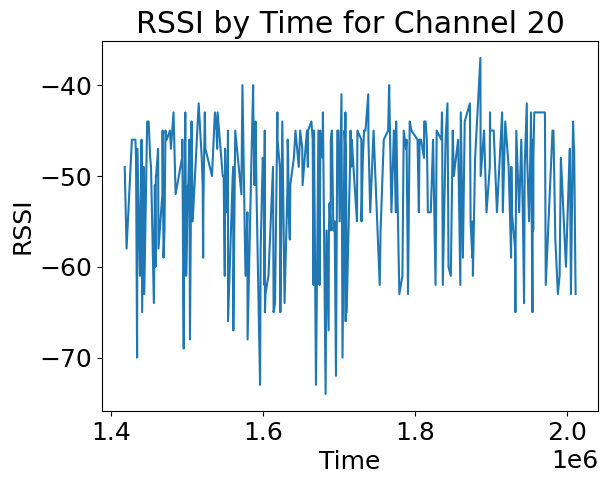

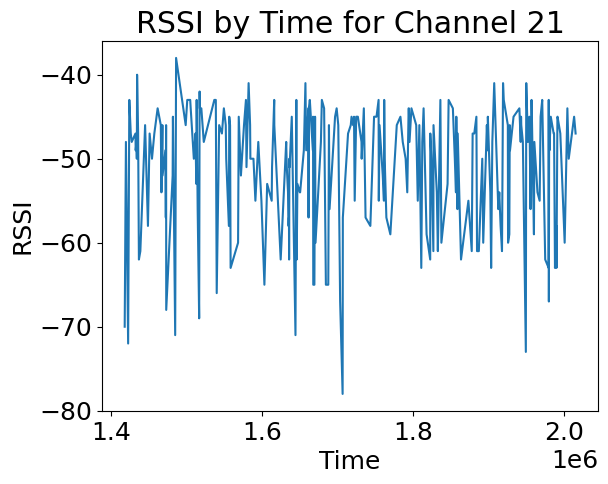

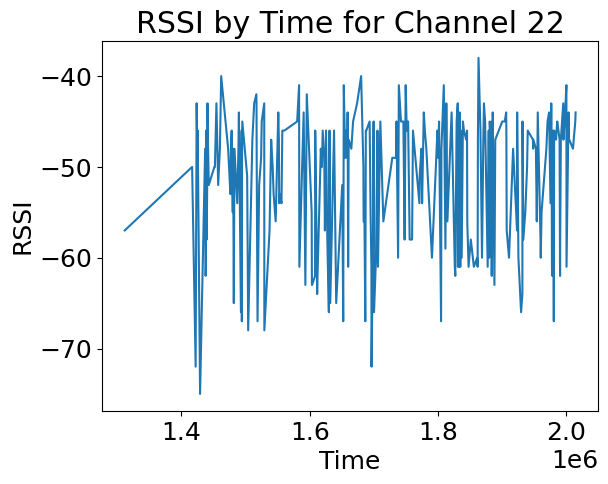

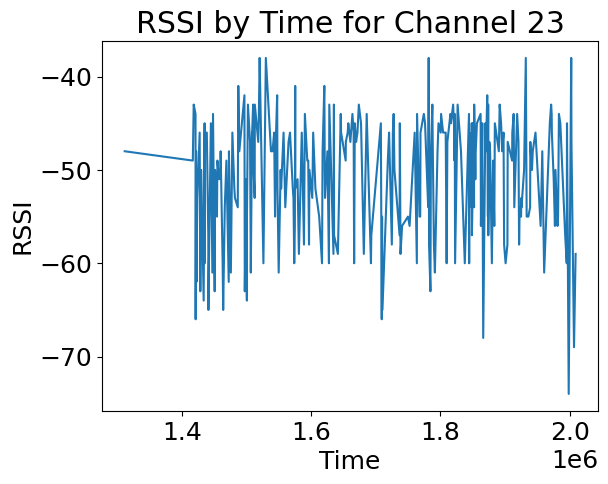

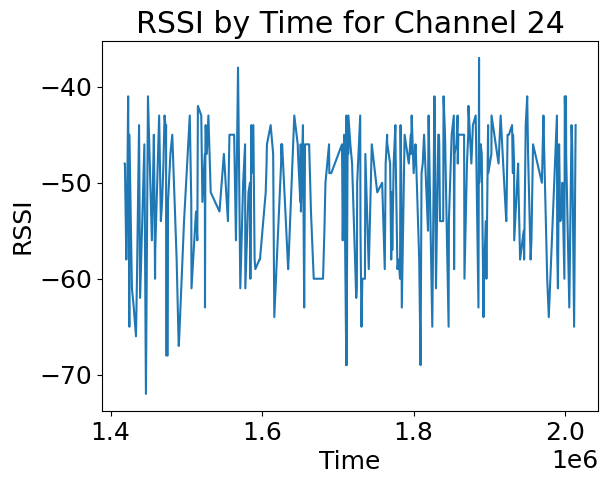

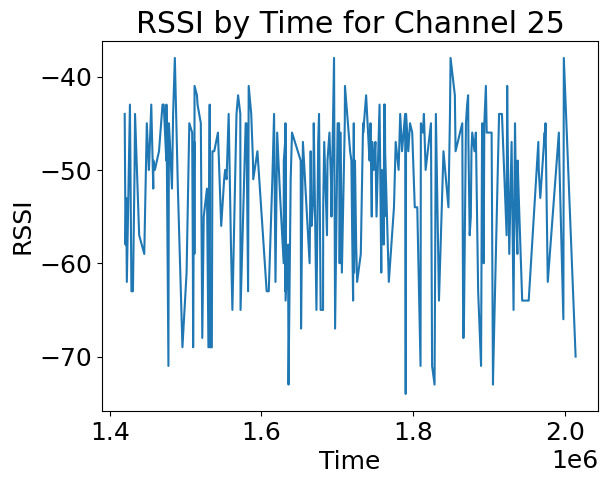

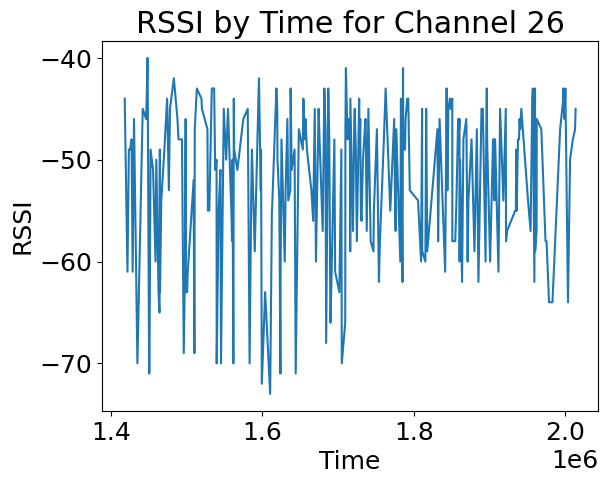

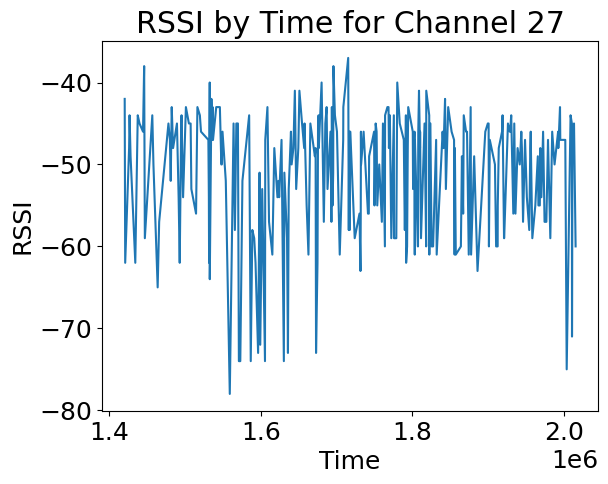

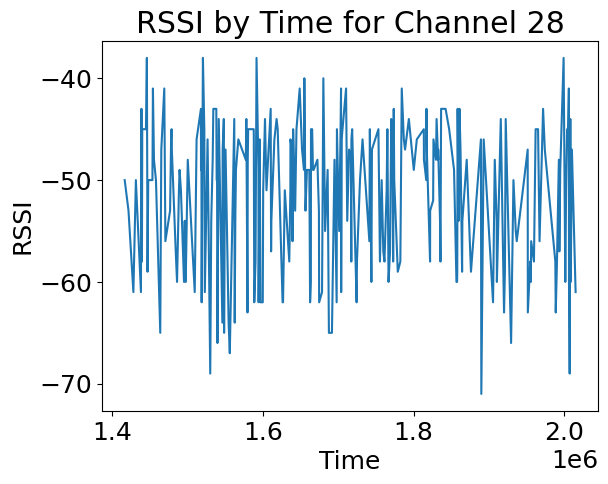

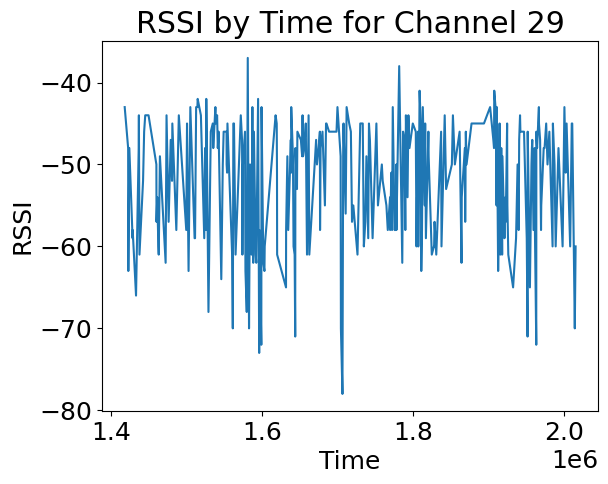

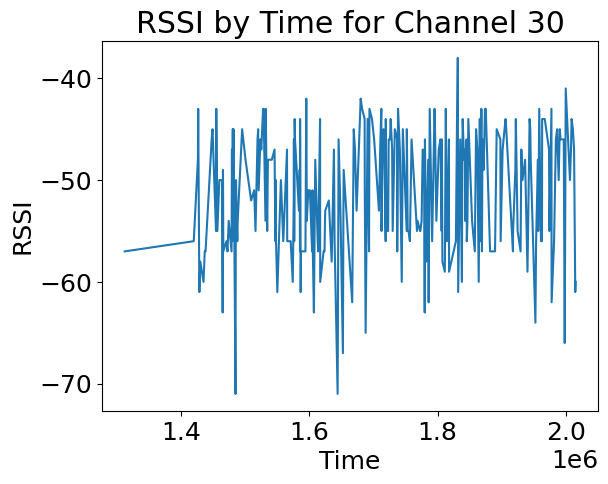

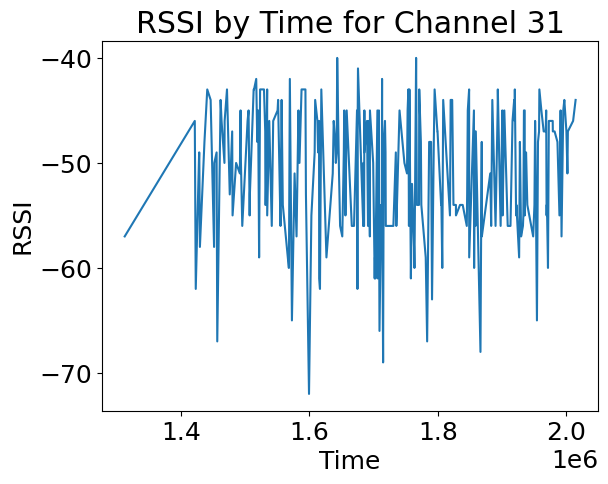

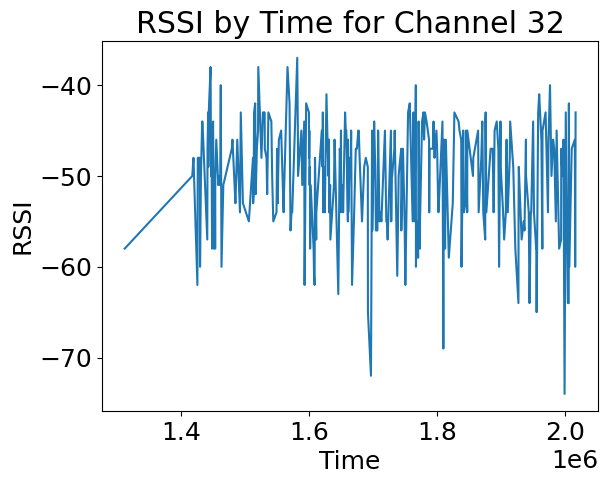

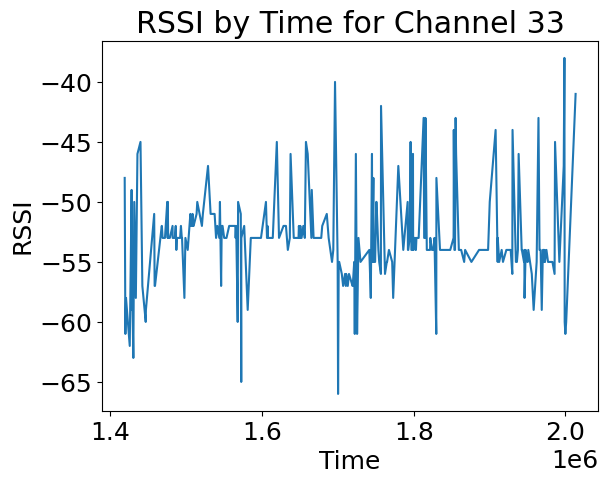

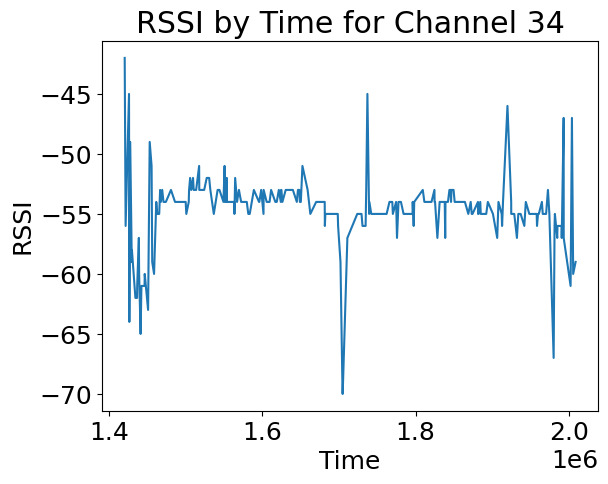

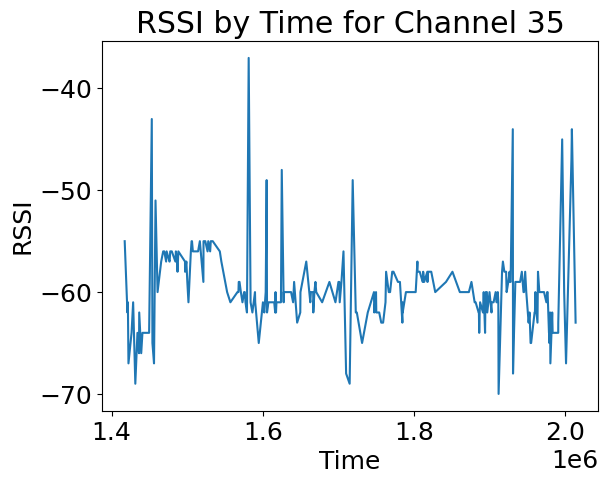

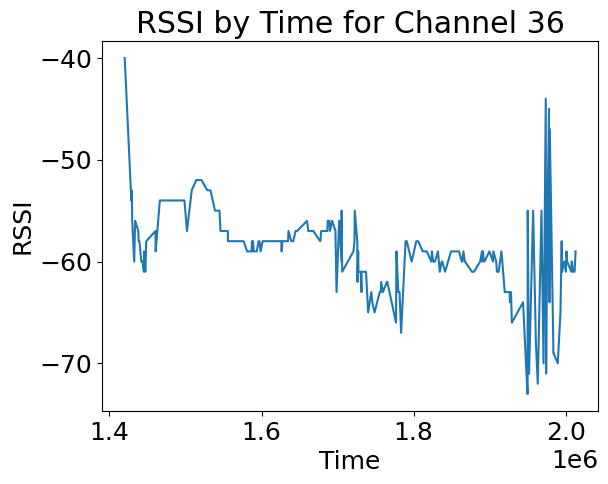

In [115]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot RSSI by time for each channel
for channel, group in grouped_data:
    plt.plot(group['time'], group['rssi'])
    plt.title('RSSI by Time for Channel {}'.format(channel))
    plt.xlabel('Time')
    plt.ylabel('RSSI')
    plt.show()

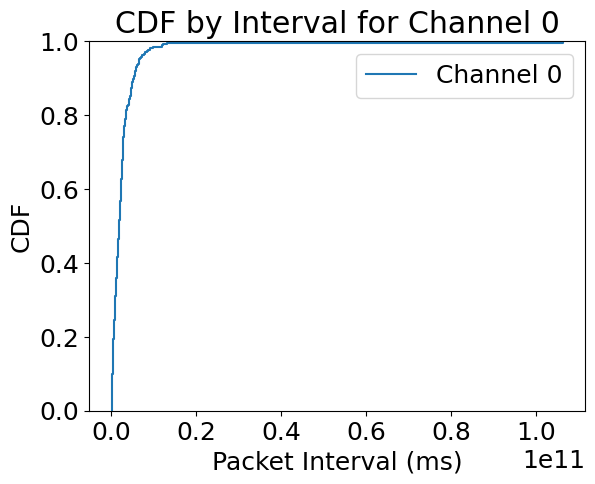

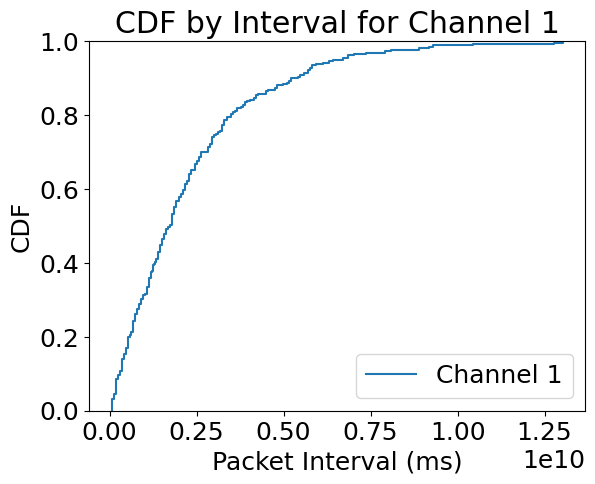

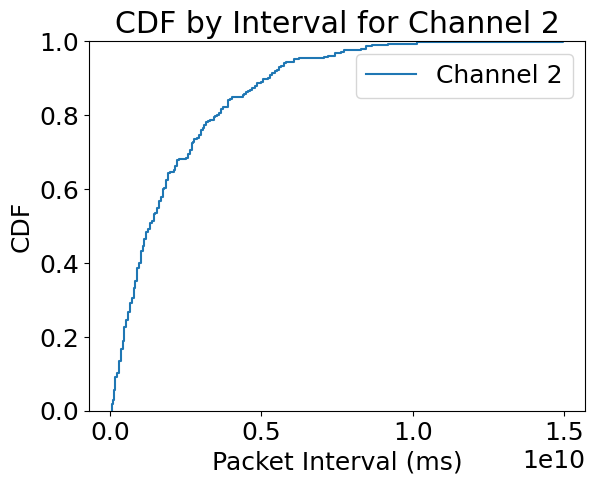

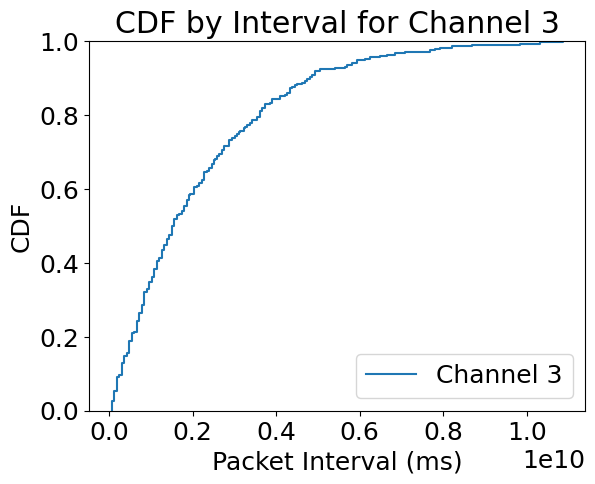

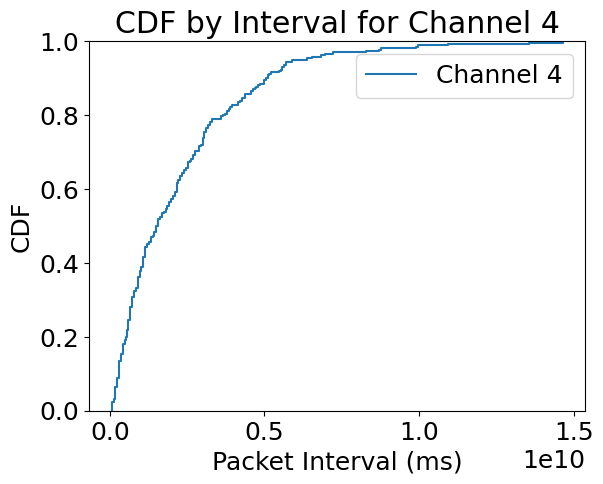

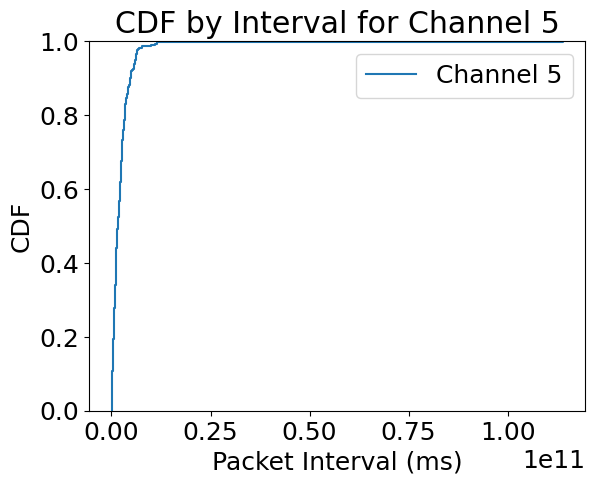

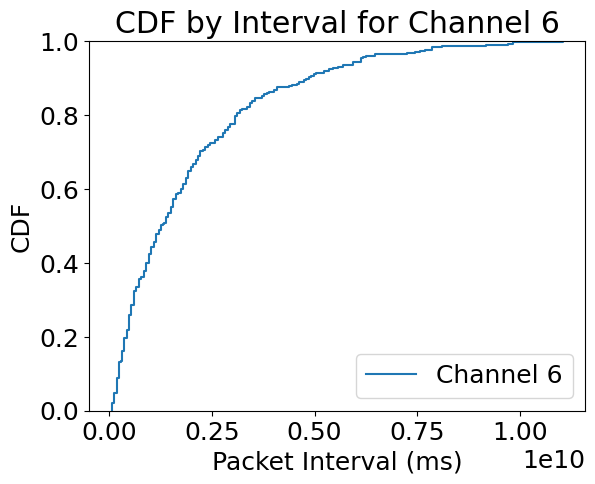

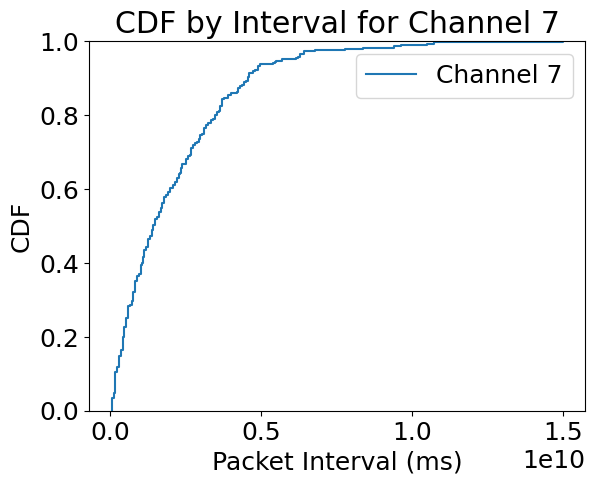

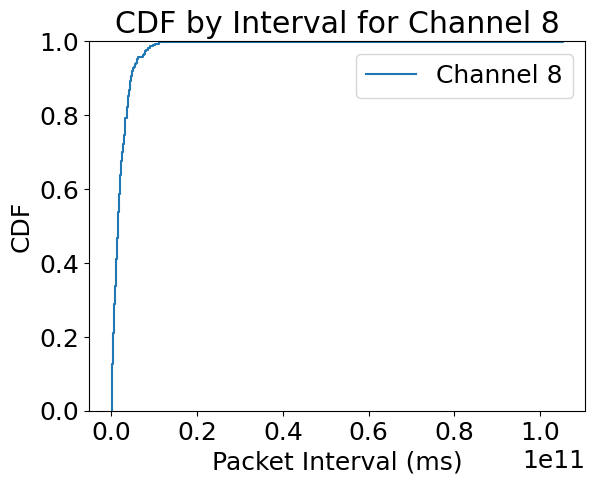

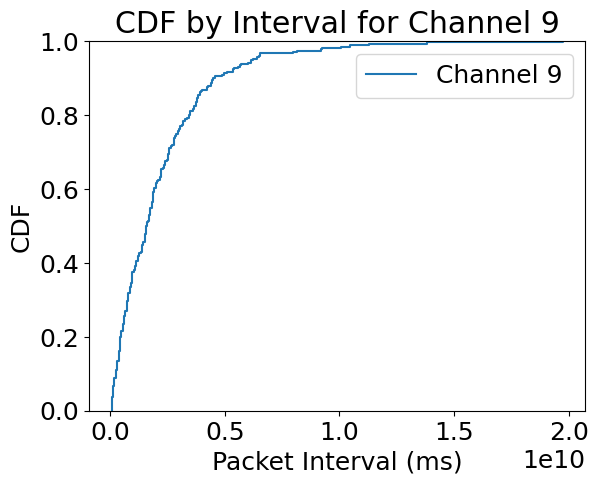

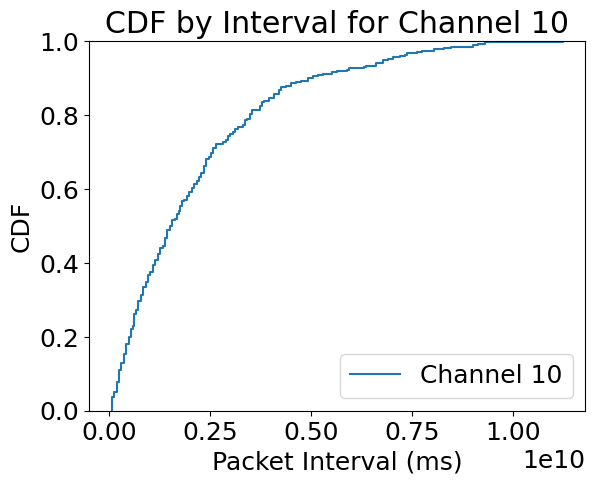

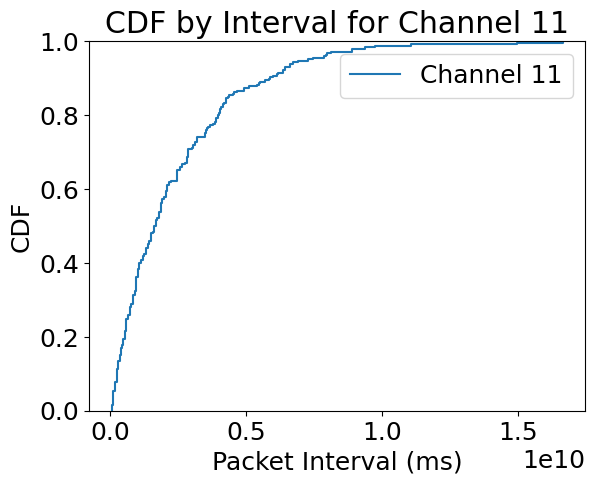

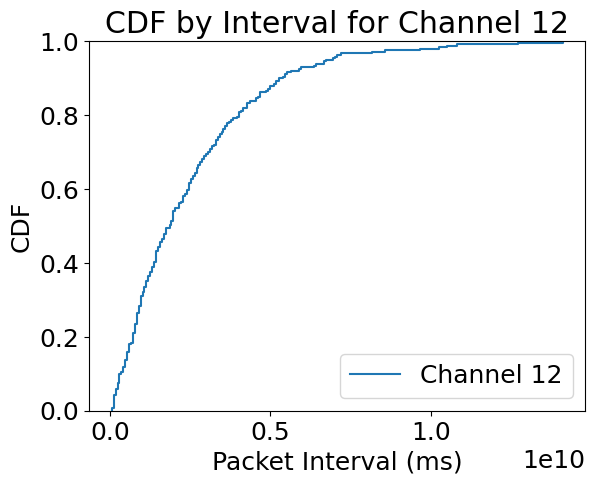

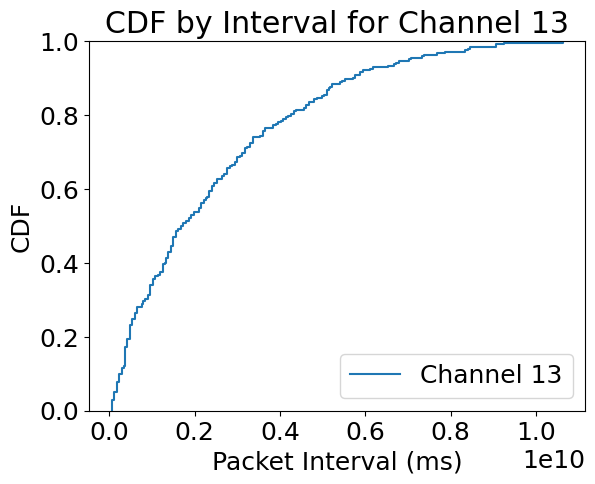

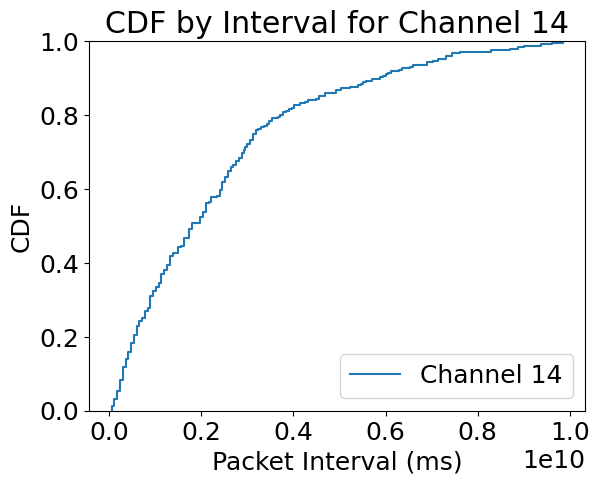

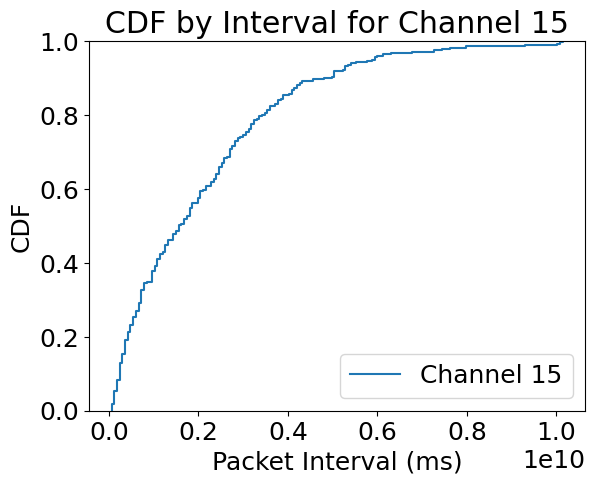

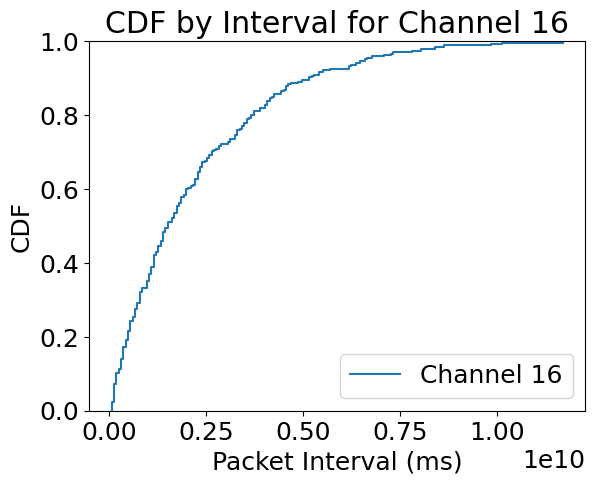

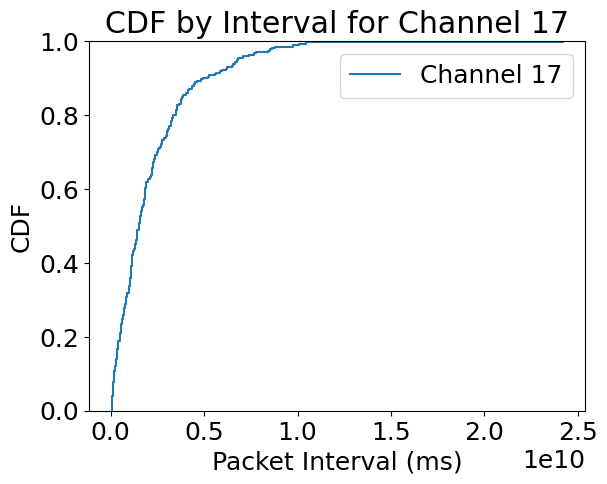

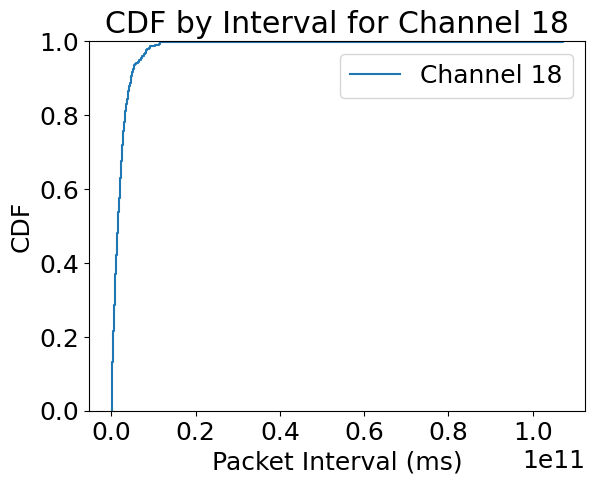

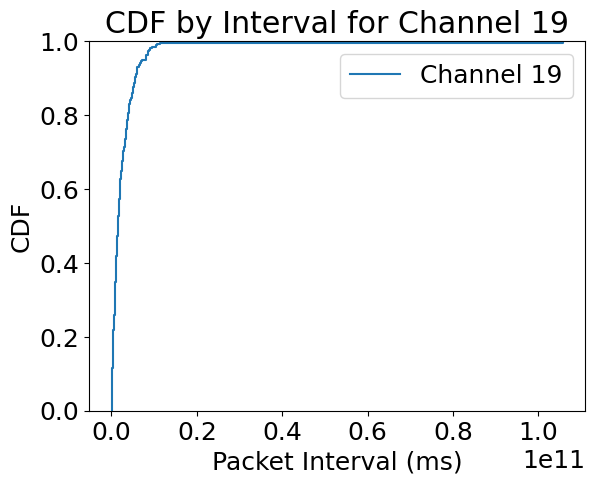

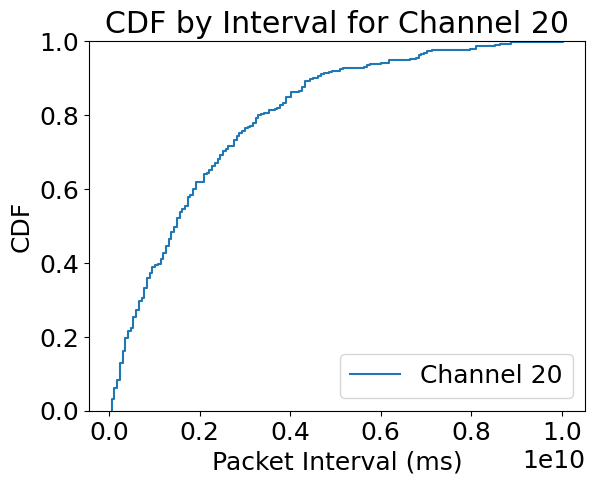

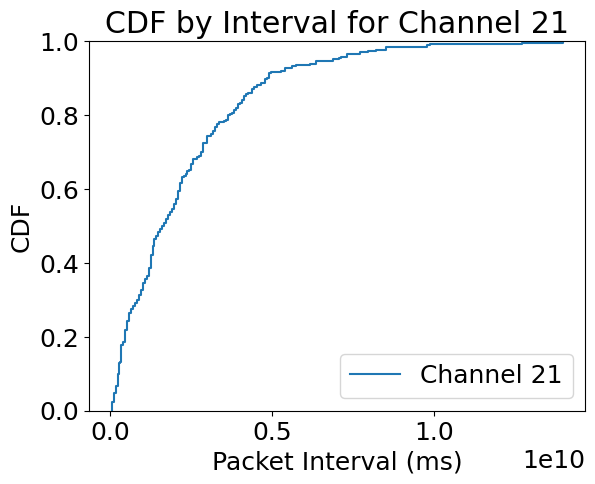

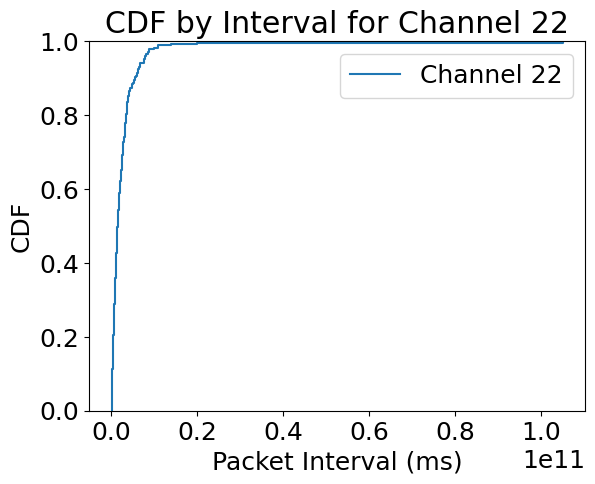

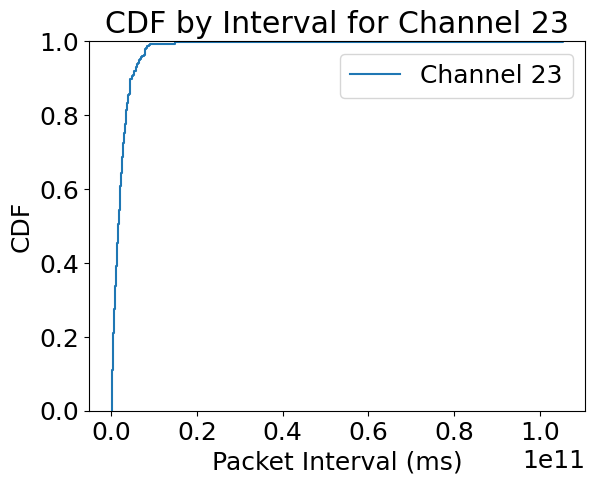

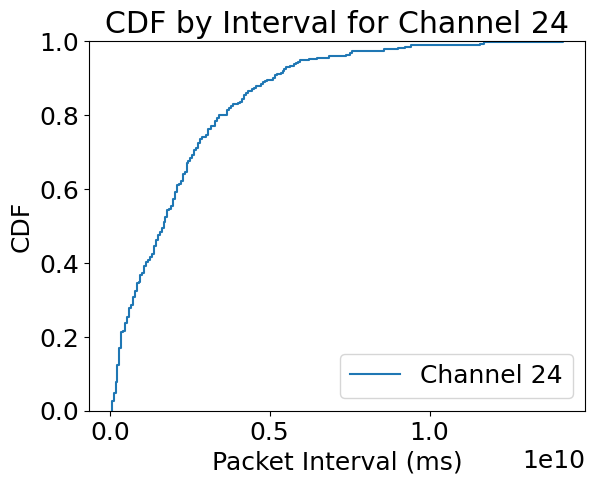

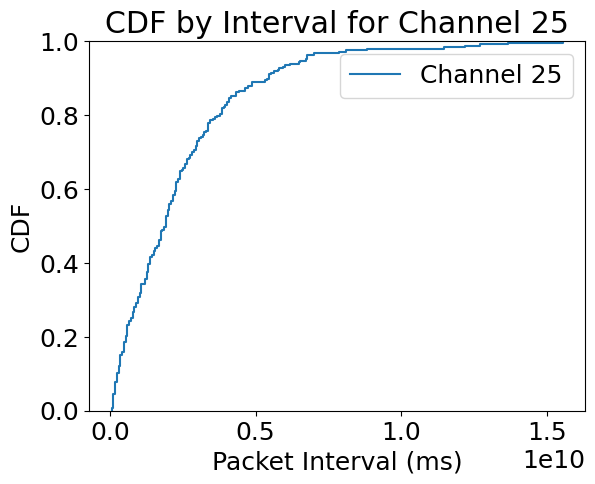

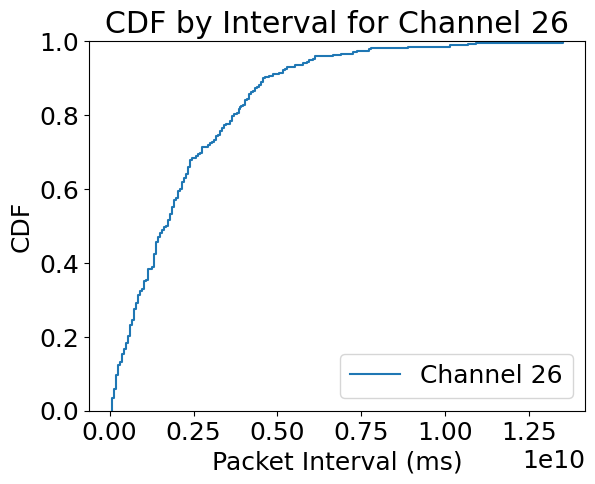

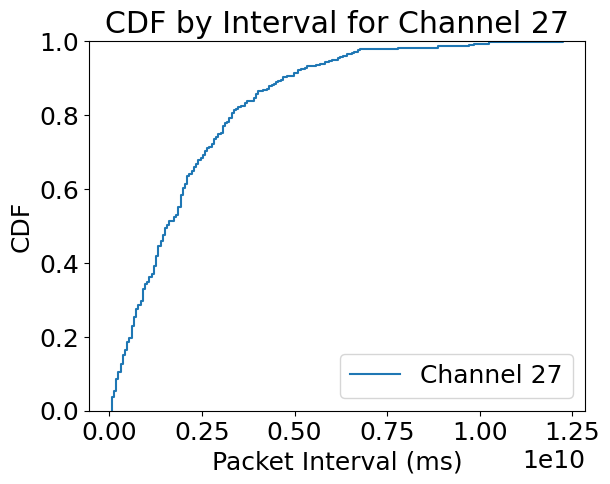

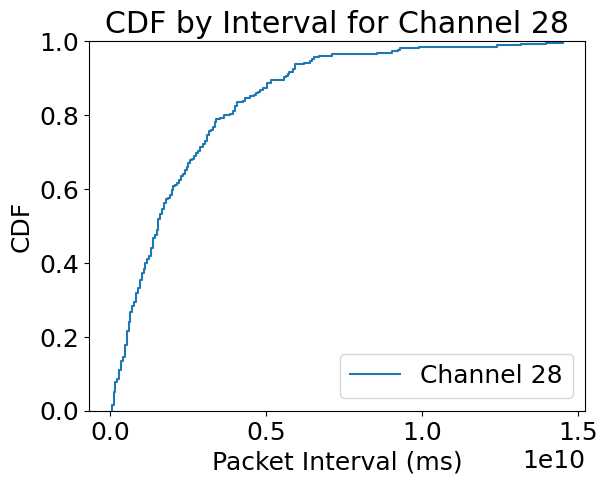

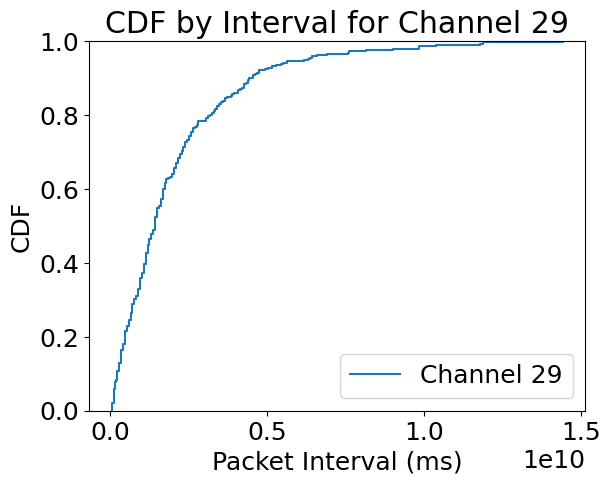

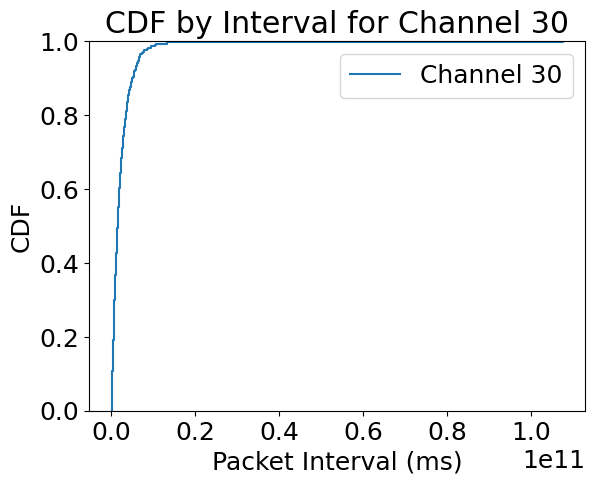

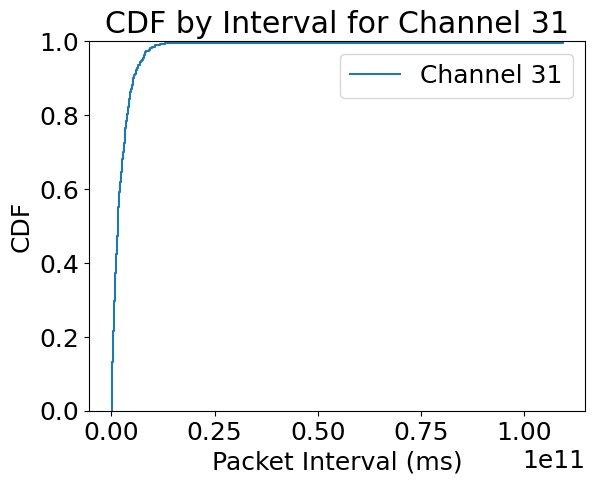

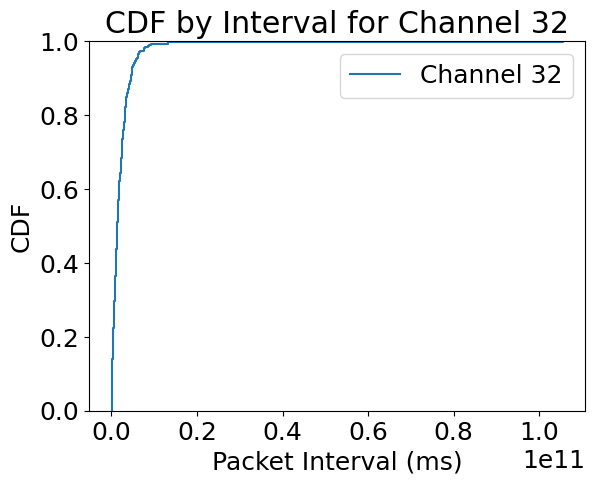

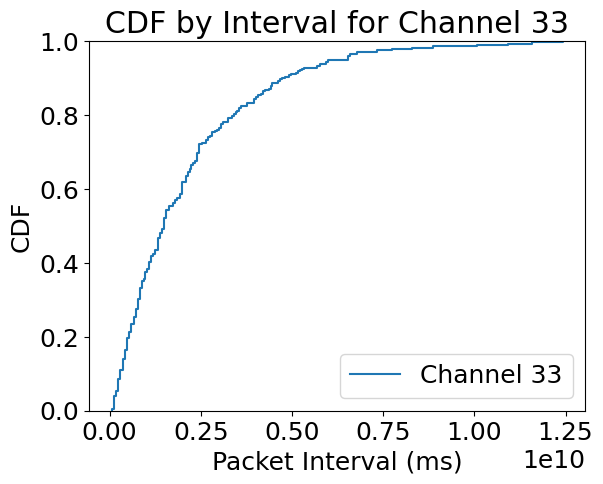

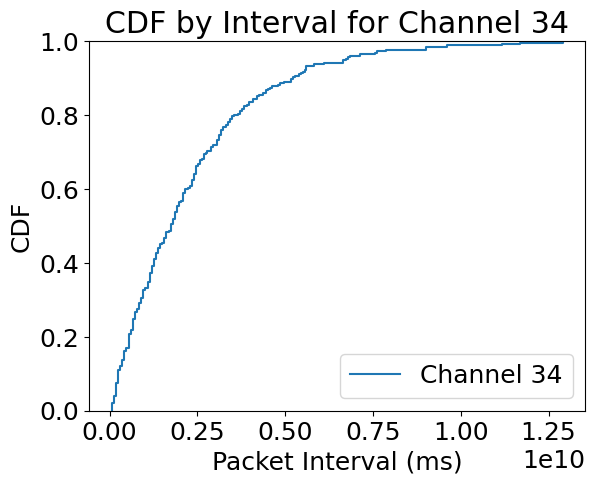

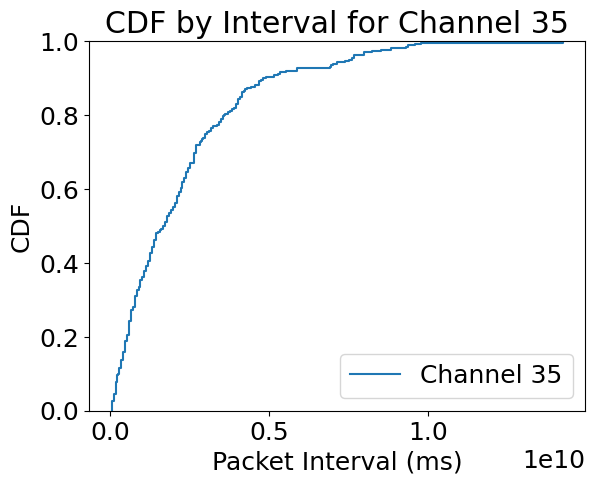

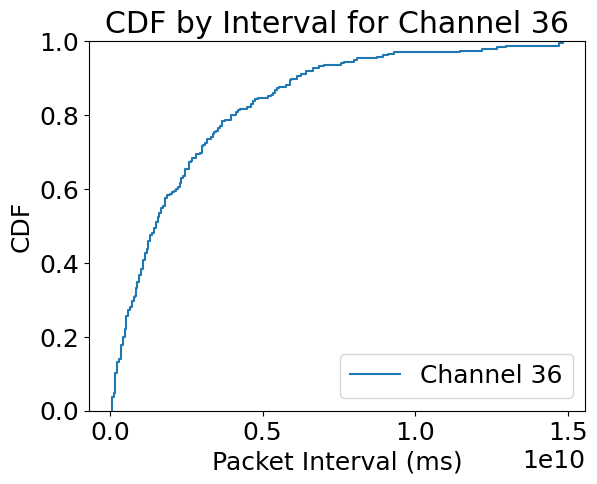

In [116]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot ECDF for each channel
for channel, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Channel {channel}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval for Channel {}'.format(channel))

    # Show plot
    plt.show()

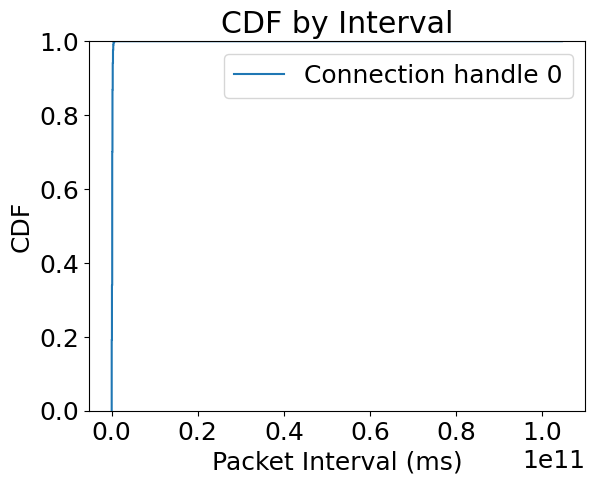

In [117]:
# Group data by connection handle
grouped_data = dfs['g1']['vs'].groupby('conn_handle')

# Plot ECDF for each connection handle
for connectionhandle, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Connection handle {connectionhandle}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval')

    # Show plot
    plt.show()

In [118]:
dfs['g1']['vs']

time  conn_handle   cc              timedelta delayed
0     1311496            0  170 0 days 00:21:51.496000     0.0
1     1311736            0  171 0 days 00:21:51.736000     1.0
2     1312036            0  172 0 days 00:21:52.036000     1.0
3     1312096            0  173 0 days 00:21:52.096000     0.0
4     1416856            0   22 0 days 00:23:36.856000     1.0
...       ...          ...  ...                    ...     ...
4991  2015416            0  145 0 days 00:33:35.416000     1.0
4992  2015417            0  146 0 days 00:33:35.417000     0.0
4993  2015536            0  147 0 days 00:33:35.536000     0.0
4994  2015596            0  148 0 days 00:33:35.596000     0.0
4995  2015716            0  149 0 days 00:33:35.716000     0.0

[4996 rows x 5 columns]